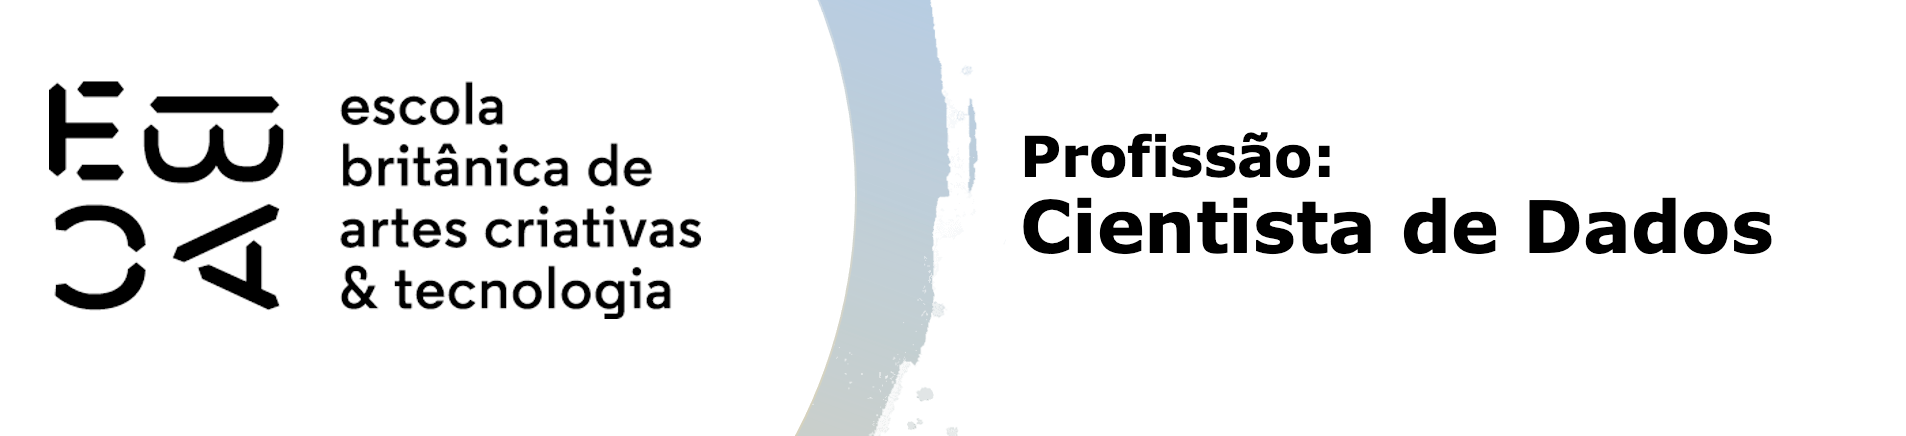

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Vamos resgatar a melhor versão do modelo de previsão de renda que foi feito para esta base, mas primeiro, vamos carregar, tratar e dividir a base em treino e teste.

# Regressão IV - Tarefa

Para iniciar as análises, vamos importar os pacotes que serão utilizados:

In [367]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import warnings


warnings.filterwarnings("ignore")
%matplotlib inline

from scipy.interpolate import interp1d
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.decomposition import PCA

### Carregamento e Tratamento dos Dados:

In [369]:
#carregando dados:
df = pd.read_csv('previsao_de_renda_II.csv')
#exibindo dados:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


Agora vamos verificar os tipos dos nossos dados para ver se estão no formato correto:

In [371]:
df.dtypes

data_ref                  object
index                      int64
sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
dtype: object

A princípio, vamos alterar apenas o formato da variável *data_ref para datetime*.

In [373]:
df['data_ref']=pd.to_datetime(df['data_ref'])
df.dtypes

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
dtype: object

Feito isso, vamos verificar se há dados faltantes no nosso df:

In [375]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

Temos um número expressivo de dados faltantes para tempo de emprego. Uma possível causa é que pode se tratar de pessoas desempregadas e por isso não consta, mas para efeito desse exercício, que tem como objetivo linearizar relações não lineares, iremos apenas substituir esses valores faltantes pela média. 

Mas primeiro, vejamos qual é o nosso número de observações para cada variável:

In [377]:
df.count()

data_ref                 750000
index                    750000
sexo                     750000
posse_de_veiculo         750000
posse_de_imovel          750000
qtd_filhos               750000
tipo_renda               750000
educacao                 750000
estado_civil             750000
tipo_residencia          750000
idade                    750000
tempo_emprego            624240
qt_pessoas_residencia    750000
renda                    750000
dtype: int64

Temos um número muito grande de observações, vejamos quanto por cento, representam os dados faltantes da variável tempo_emprego:

In [379]:
125760/750000 * 100

16.768

Temos então que 16,7% dos valores tempo_emprego não estão preenchidos, esses serão, como informado anteriormente, substituídos pela média.

In [381]:
#calculando a média de tempo_emprego:
media_tempo_emprego= df['tempo_emprego'].mean()
#preenchendo os faltantes com a média calculada:
df['tempo_emprego']= df['tempo_emprego'].fillna(media_tempo_emprego)
#contagem dos faltantes por variável:
df.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

Como exibido acima, não há mais valores faltantes no nosso df, logo, conseguimos realizar o preenchimento dos valores faltantes com a média.

O nosso próximo passo de preparo dos dados é **separar os últimos três meses de observações do nosso df para serem nossa base de teste, o restante será nossa base de treino.**

In [383]:
df['data_ref'].describe()

count                 750000
mean     2015-08-01 06:24:00
min      2015-01-01 00:00:00
25%      2015-04-01 00:00:00
50%      2015-08-01 00:00:00
75%      2015-12-01 00:00:00
max      2016-03-01 00:00:00
Name: data_ref, dtype: object

In [384]:
#converte as datas em períodos mensais, retorna os períodos unicos em data crescente e seleciona os três ultimos
df['data_ref'].dt.to_period('M').unique()[-3:]

<PeriodArray>
['2016-01', '2016-02', '2016-03']
Length: 3, dtype: period[M]

Vimos acima que a nossa base vai de janeiro de 2015 à março de 2016 e que os últimos três meses são também os 3 primeiros meses do ano de 2016, esses serão os meses para teste.

A seguir, vamos tornar a data o nosso índice e deixá-lo em ordem cronológica:

In [386]:
#ordenando
df = df.sort_values('data_ref')
df.head(2)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
33328,2015-01-01,13463,F,S,N,0,Assalariado,Superior completo,União,Casa,26,2.347945,2.0,1684.88


Feita a organização, vamos separar os últimos três meses para teste:

In [388]:
# Separando os conjuntos de treinamento e teste
df_treino = df[df['data_ref'] <= '2015-12-31']  # Até dezembro de 2015
df_teste = df[df['data_ref'] >= '2016-01-01']   # A partir de janeiro de 2016
df_teste.head(2)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
633328,2016-01-01,5766,F,S,N,0,Pensionista,Superior completo,Solteiro,Casa,63,7.746165,1.0,1364.05
633329,2016-01-01,567,F,N,S,0,Pensionista,Médio,Casado,Casa,59,7.746165,2.0,4856.40


Agora, antes de iniciar as nossas análises, vamos realizar mais um ajuste no nosso dataframe de treino, que é **criar a coluna log de renda**, faremos esse procedimento pois ele torna a distribuição dessa variável mais próxima do normal, permitindo a criação de modelos mais estáveis e precisos. 

In [390]:
#adicionando a coluna log de renda aos dfs:
df_treino['log_renda']= np.log(df_treino['renda'])
df_treino.head(2)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131
33328,2015-01-01,13463,F,S,N,0,Assalariado,Superior completo,União,Casa,26,2.347945,2.0,1684.88,7.429450


Encerramos o nosso tratamento de dados e divisão de bases. Agora vamos resgatar o modelo escolhido na tarefa anterior.

### Melhor modelo encontrado na tarefa anterior:

Relembrando como se saíram os modelos testados:

| Modelo       | R²-ajustado (%) - Treino | R²-ajustado (%) - Teste |
|--------------|--------------------------|--------------------------|
| *Modelo 1*   |        42,37             |         52,95                   |
| *Modelo 2*   |        42,37             |         52,95                   |
| *Modelo 3*   |        41,74             |         51,16                   |
| *Modelo 4*   |        99,30             |         99,32                   |
| *Modelo 5*   |        42,60             |         53,27                   |

Logo, ficaremos com o modelo número 5. 

*Obs: a variável alvo é log_renda.*

As variáveis utilizadas no modelo 5 são:

- Posse de imóvel;
- Quantidade de filhos;
- Idade;
- Tempo de emprego (LOWESS);

A seguir, vamos criar um novo df apenas com essas variáveis e log_renda que é nossa variável alvo e em seguida, rodar o modelo que é log_renda explicada pelas demais varáveis com tempo_emprego suavizado.

In [394]:
df_treino_b = df_treino[['log_renda', 'posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego']]

In [395]:
#Quinto modelo: Com Suavização LOWESS
lowess = sm.nonparametric.lowess(df_treino_b['log_renda'], df_treino_b['tempo_emprego'], frac=2/3)
f = interp1d(lowess[:, 0], lowess[:, 1], bounds_error=False)

df_treino_b['tempo_emprego_lowess'] = f(df_treino_b['tempo_emprego'])

X2 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_lowess 
                    + 1''', df_treino_b)

res = smf.ols(X2, data=df_treino_b).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                 1.113e+05
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:33:47   Log-Likelihood:            -8.0368e+05
No. Observations:              600000   AIC:                         1.607e+06
Df Residuals:                  599995   BIC:                         1.607e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0569      0.014     -3.962      0.000      -0.085      -0.029
C(posse_de_imovel)[T.S]     0.1802      0.003     70.260      0.000       0.175       0.185
qtd_filhos                  0.0062      0.002      3.561      0.000       0.003       0.010
idade                      -0.0040      0.000    -33.842      0.000      -0.004      -0.004
tempo_emprego_lowess        1.0106      0.002    653.091      0.000       1.008       1.014
==============================================================================
Omnibus:                      967.813   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              859.945
Skew:                          -0.050   Prob(JB):                    1.84e-187
Kurtosis:                       2.844   Cond. No.                         558.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Agora que já rodamos o modelo com maior desempenho, temos tudo pronto para começar analisar as suposições do modelo. Vamos lá!

## Verificando as suposições do modelo:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verificação da independência dos resíduos;
    - Gráfico dos resíduos versus os valores preditos;
    - Avaliar se há padrões dos resíduos versus cada uma das variáveis do modelo;
    - Avaliar se o valor médio dos resíduos aparenta ter relação com o mês de referência;
- Avaliar se a variância da variável resposta parece ser conforme os valores previstos;

#Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

**Para iniciar nossa análise, vamos observar um histograma para avaliar a distribuição dos resíduos:**

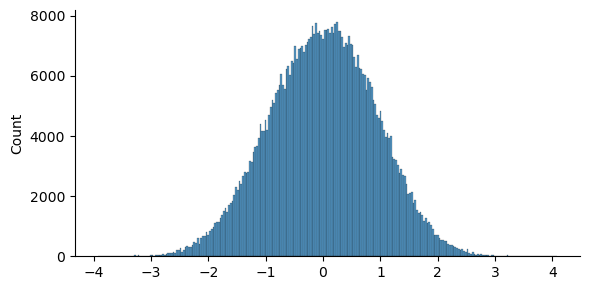

In [399]:
sns.displot(res.resid, height=3, aspect=2);

O ideal é que esse tipo de histograma tenha realmente a aparencia de um sino e é praticamente isso que ocorre aqui com valores bem distribuídos em torno do 0 e caudas que não aprensentam desvios muito evidentes. **Aparentemente que temos uma distribuição bem próxima do normal.**

*Entretanto, vamos continuar nossa análise para confirmar essa teoria. Prosseguiremos com um gráfico de resíduos versus valores preditos:*

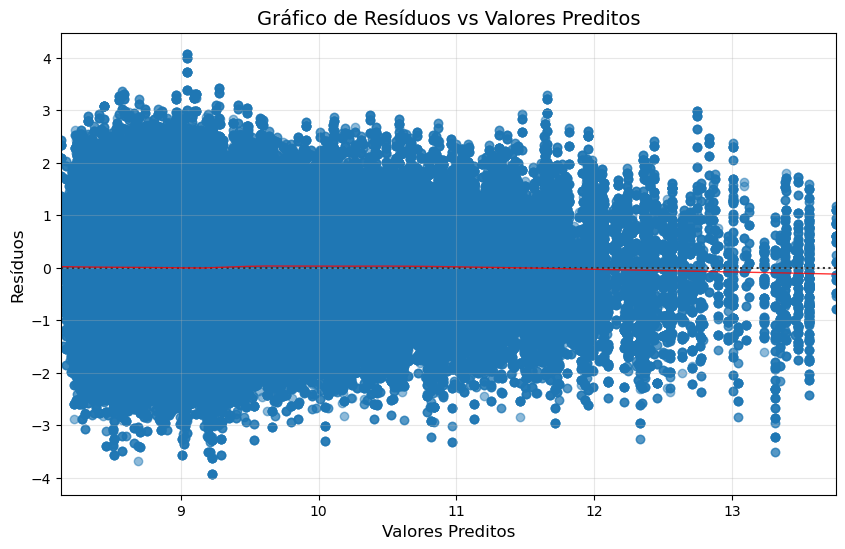

In [401]:
# Gráfico de resíduos x valores preditos
plt.figure(figsize=(10, 6))
sns.residplot(
    x=res.predict(),          # Valores preditos pelo modelo
    y=res.resid,              # Resíduos calculados
    lowess=True,              # Adiciona a linha suavizada (LOWESS)
    scatter_kws={'alpha': 0.5},  # Estilo dos pontos
    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}  # Estilo da linha LOWESS
)
plt.title('Gráfico de Resíduos vs Valores Preditos', fontsize=14)
plt.xlabel('Valores Preditos', fontsize=12)
plt.ylabel('Resíduos', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

O resíduo de log_renda está centrado no zero. Quando a variancia aumenta com o resíduo, dá-se o nome de heteroscedastidade.

**Quanto mais perto a linha vermelha (lowess) tiver do 0 melhor e é basicamente isso que temos**, com um desvio bem leve dela para valores preditos maiores que 12.

A seguir, para entender melhor essa distribuição dos resíduos e como ela é composta, vamos analisá-la para cada uma das variáveis de forma separada.

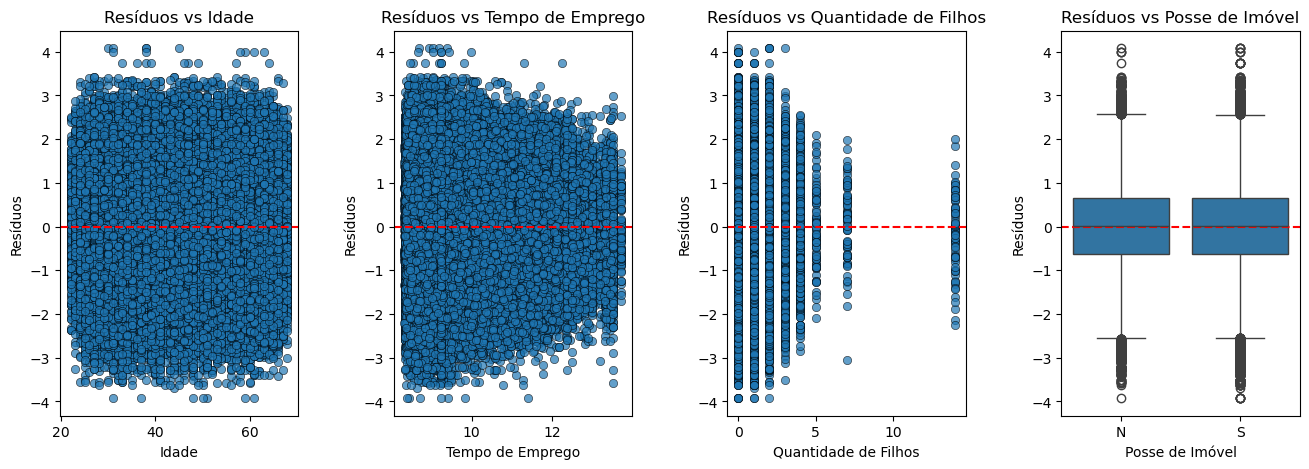

In [403]:
# Gerar gráficos para avaliar resíduos vs variáveis do modelo
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
plt.subplots_adjust(wspace=0.4)

# Resíduos x Idade
sns.scatterplot(x='idade', y=res.resid, data=df_treino_b, ax=ax[0], alpha=0.7, edgecolor='k')
ax[0].axhline(0, color='red', linestyle='--', linewidth=1.5)
ax[0].set_title('Resíduos vs Idade')
ax[0].set_xlabel('Idade')
ax[0].set_ylabel('Resíduos')

# Resíduos x Tempo de Emprego
sns.scatterplot(x='tempo_emprego_lowess', y=res.resid, data=df_treino_b, ax=ax[1], alpha=0.7, edgecolor='k')
ax[1].axhline(0, color='red', linestyle='--', linewidth=1.5)
ax[1].set_title('Resíduos vs Tempo de Emprego')
ax[1].set_xlabel('Tempo de Emprego')
ax[1].set_ylabel('Resíduos')

# Resíduos x Quantidade de Filhos
sns.scatterplot(x='qtd_filhos', y=res.resid, data=df_treino_b, ax=ax[2], alpha=0.7, edgecolor='k')
ax[2].axhline(0, color='red', linestyle='--', linewidth=1.5)
ax[2].set_title('Resíduos vs Quantidade de Filhos')
ax[2].set_xlabel('Quantidade de Filhos')
ax[2].set_ylabel('Resíduos')

# Resíduos x Posse de Imóvel
sns.boxplot(x='posse_de_imovel', y=res.resid, data=df_treino_b, ax=ax[3])
ax[3].axhline(0, color='red', linestyle='--', linewidth=1.5)
ax[3].set_title('Resíduos vs Posse de Imóvel')
ax[3].set_xlabel('Posse de Imóvel')
ax[3].set_ylabel('Resíduos')

#exibindo os gráficos:
plt.show()


*Geralmente em um modelo bem ajustado, temos os resíduos  (diferença entre os valores observados e os valores previstos pelo modelo)  próximos do zero, em uma faixa de valores entre 3 e -3 e dispersos aleatóriamente sem possuir um padrão.*

- A idade atende bem as exigencias citadas acima, apesar de ter alguns valores extrapolando a faixa de 3 e -3, não são muitos e no geral a distribuição se compota bem, o que indica que o modelo está fazendo boas previsões.

- O tempo de emprego no geral também se comporta bem, mas apresenta ai uma espécie de afunilamento, não tão marcante mas ainda assim pode indicar que há alguns outliers e em alguns casos é entendivel, pois nem sempre significa que são valores não reais, mas sim valores afastados dos demais, como é o caso de uma pessoa com 14 filhos, incomum mas possível.


- A quantidade de filhos apresenta um afunilamento visível, talvez essa variável não seja a mais adequada para estar no modelo. 

- Posse de imóvel também apresenta outliers para renda de acordo com cada classe (s/n).

Apresentar outliers em um banco de dados com mais de 500 mil observações é bem comum, como já mencionado, nem sempre significa que esses outliers são entradas erradas, mas sim, valores que estão mais distantes da normalidade. 

*Para finalizar os gráficos dos resíduos, vamos verificar como se comportam a média dos resíduos ao longo dos meses*, para vermos se há alguma diferença significativa, como para treino temos apenas o ano de 2015, basta 'retirar' o mês da 'data-ref'.

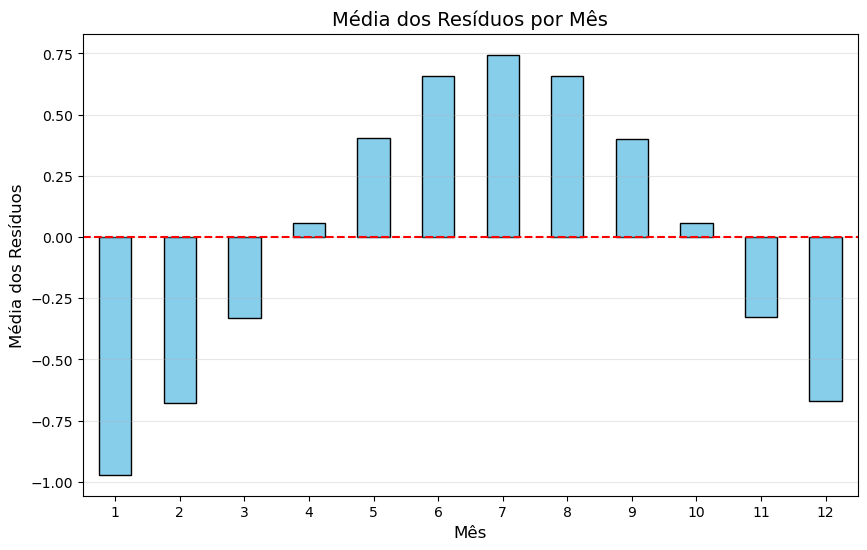

In [405]:
#selecionando o mês e tornando-o categórico:
df_treino_b['mes'] = df_treino['data_ref'].dt.month.astype('category')

#calculando a media dos resíduos por mês
media_residuos_por_mes = res.resid.groupby(df_treino_b['mes']).mean()

#plotando o gfráfico:
plt.figure(figsize=(10, 6))
media_residuos_por_mes.plot(kind='bar', color='skyblue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title('Média dos Resíduos por Mês', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Média dos Resíduos', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.show()


Nos três primeiros meses e dois últimos meses do ano os resíduos são negativos, já para o restante, eles são positivos.

**Apenas para efeito de curiosidade**, *vamos ver como se comportaria um modelo em que usassemos os meses para realizar a previsão:* 

In [407]:
#Quinto modelo: Com Suavização LOWESS
X2 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + mes
                    + tempo_emprego_lowess 
                    + 1''', df_treino_b)

res_teste = smf.ols(X2, data=df_treino_b).fit()
res_teste.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                 7.119e+04
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:40:48   Log-Likelihood:            -6.6353e+05
No. Observations:              600000   AIC:                         1.327e+06
Df Residuals:                  599984   BIC:                         1.327e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.0328      0.012    -87.564      0.000      -1.056      -1.010
C(posse_de_imovel)[T.S]     0.1800      0.002     88.650      0.000       0.176       0.184
mes[T.2]                    0.2919      0.005     63.121      0.000       0.283       0.301
mes[T.3]                    0.6414      0.005    138.683      0.000       0.632       0.650
mes[T.4]                    1.0282      0.005    222.337      0.000       1.019       1.037
mes[T.5]                    1.3739      0.005    297.072      0.000       1.365       1.383
mes[T.6]                    1.6294      0.005    352.322      0.000       1.620       1.638
mes[T.7]                    1.7159      0.005    371.036      0.000       1.707       1.725
mes[T.8]                    1.6287      0.005    352.169      0.000       1.620       1.638
mes[T.9]                    1.3715      0.005    296.570      0.000       1.362       1.381
mes[T.10]                   1.0293      0.005    222.560      0.000       1.020       1.038
mes[T.11]                   0.6439      0.005    139.220      0.000       0.635       0.653
mes[T.12]                   0.3000      0.005     64.866      0.000       0.291       0.309
qtd_filhos                  0.0083      0.001      6.033      0.000       0.006       0.011
idade                      -0.0040   9.38e-05    -42.812      0.000      -0.004      -0.004
tempo_emprego_lowess        1.0111      0.001    825.278      0.000       1.009       1.013
==============================================================================
Omnibus:                       62.978   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.115
Skew:                           0.003   Prob(JB):                     4.40e-15
Kurtosis:                       3.051   Cond. No.                         638.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Esse novo *modelo teste* nos trouxe um aumento significativo no $R^2$, mas **como não usaremos a data para previsões, esse modelo foi apenas para efeito de curiosidade.** 

Vamos prosseguir com a análise e descobrir quais os outliers que o gráfico de resíduos nos mostrava.

## Outliers

Avaliaremos os *studentized residuals*, verificando se há pontos que parecem ser discrepantes.

Diferente dos resíduos simples, os resíduos studentized não apenas medem o quão distante uma observação está do valor ajustado, mas também consideram a incerteza associada a essa previsão. Eles são importantes para avaliar a qualidade e adequação de um modelo de regressão. 

Posteriormente, buscaremos por pontos influentes.

Índices de pontos discrepantes: (array([   109,    290,    361, ..., 599123, 599265, 599362], dtype=int64),)


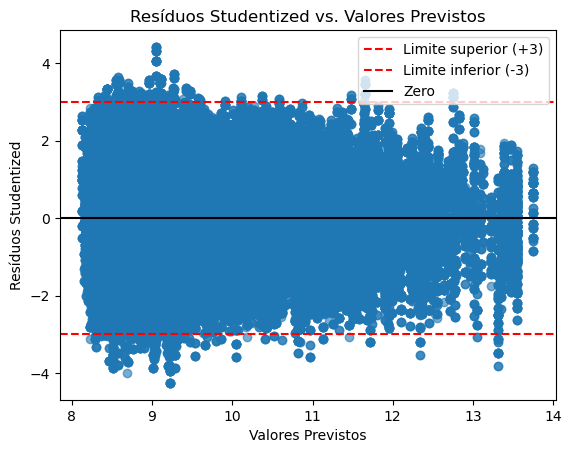

In [410]:
# Fórmula do modelo que estamos usando:
formula = '''log_renda ~ 
             C(posse_de_imovel) 
             + qtd_filhos 
             + idade 
             + tempo_emprego_lowess'''

# Gerando as matrizes X (variáveis independentes) e y (variável dependente):
y, X = patsy.dmatrices(formula, df_treino_b)

# Ajustando o modelo de regressão
model = sm.OLS(y, X).fit()

# Obtendo os resíduos studentized:
influence = model.get_influence()
studentized_residuals = influence.resid_studentized_internal

# Identificando valores extremos (fora de [-3, 3]):
extremos = np.where((studentized_residuals > 3) | (studentized_residuals < -3))
print("Índices de pontos discrepantes:", extremos)

# Obtendo valores previstos (fitted values):
fitted_values = model.fittedvalues

# Visualizando os resíduos studentized:
plt.scatter(fitted_values, studentized_residuals, alpha=0.6)
plt.axhline(y=3, color='r', linestyle='--', label='Limite superior (+3)')
plt.axhline(y=-3, color='r', linestyle='--', label='Limite inferior (-3)')
plt.axhline(y=0, color='black', linestyle='-', label='Zero')
plt.xlabel("Valores Previstos")
plt.ylabel("Resíduos Studentized")
plt.title("Resíduos Studentized vs. Valores Previstos")
plt.legend()
plt.show()


Com esse novo gráfico, onde usamos os resíduos studentized e aplicamos as faixas [-3, 3], conseguimos perceber melhor os pontos fora dessa faixa, que seriam os outliers, além de termos criado uma lista chamada 'extremos' que nos traz quais são esses pontos. 

*Abaixo vamos filtrar esses pontos no nosso df e ver suas características para entendermos porque são considerados outliers:*

In [412]:
# Filtrando o DataFrame pelas linhas especificadas
df_treino_b.iloc[extremos]

,log_renda,posse_de_imovel,qtd_filhos,idade,tempo_emprego,tempo_emprego_lowess,mes
33242,6.328455,N,0,40,7.746165,9.230303,1
33497,5.893907,S,0,60,7.746165,9.230303,1
33494,7.889905,N,1,41,19.890411,10.937183,1
32843,6.339583,S,0,54,7.746165,9.230303,1
33006,6.270346,S,0,53,6.210959,9.060655,1
...,...,...,...,...,...,...,...
568606,6.017157,S,1,42,7.746165,9.230303,12
568193,10.084146,N,0,64,40.786301,13.476577,12
565845,5.401190,S,2,30,0.717808,8.406553,12
566906,6.213327,N,1,40,6.958904,9.137389,12


Acima, podemos ver realmente comportamentos que fogem do padrão, como exemplo:

- **33497**: Possui idade = 60 e tempo_emprego = 7.75. A idade mais avançada combinada com o tempo de emprego moderado pode ser um padrão menos comum na base de dados, marcando essa observação como potencial outlier.

- **33494**: log_renda = 7.88 (acima da média) com tempo_emprego = 19.89 e idade = 41. Um tempo de emprego muito elevado para essa faixa etária pode destoar em relação ao padrão do conjunto de dados.

- **32843**: Semelhante a outros pontos com tempo_emprego = 7.75, sua presença como outlier pode ser de menor impacto, mas relacionada a resíduos elevados.

- **33006**: tempo_emprego = 6.21 e idade = 53. Não parece um caso extremo, mas pode ter alguma influência leve no modelo.

- **568193**: log_renda = 10.08 (valor muito alto) e tempo_emprego = 40.78 em uma idade avançada de 64 anos. Claramente um ponto influente com um padrão de longevidade no trabalho que difere do restante.

Entre os exemplos acima, temos algumas razões distintas potenciais para serem consideradas outliers, mas também, temos algumas que parecem estar dentro da normalidade. Vamos verificar a seguir quais são pontos influentes:

*Temos 1053 linhas de outliers, vamos remover para vermos como nosso modelo se comporta sem e comparar.*

In [414]:
#Deixando so extremos em formato de lista para casar:
extremos = np.array(extremos).flatten().tolist()

# Removendo os índices dos outliers do DataFrame:
df_treino_b_sem_outliers = df_treino_b.drop(index=extremos)

# Verificando o tamanho antes e depois:
print("Tamanho original:", df_treino_b.shape[0])
print("Tamanho sem outliers:", df_treino_b_sem_outliers.shape[0])

Tamanho original: 600000
Tamanho sem outliers: 598947


*Removendo os outliers a gente reduz o tamanho do nosso df em 0,1755%, vamos ver como fica nosso $R^2$ fazendo isso:*

In [415]:
#Quinto modelo: Com Suavização LOWESS
X2 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_lowess 
                    + 1''', df_treino_b_sem_outliers)

res_teste_1 = smf.ols(X2, data=df_treino_b_sem_outliers).fit()
res_teste_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                 1.112e+05
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:41:10   Log-Likelihood:            -8.0210e+05
No. Observations:              598947   AIC:                         1.604e+06
Df Residuals:                  598942   BIC:                         1.604e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0564      0.014     -3.928      0.000      -0.085      -0.028
C(posse_de_imovel)[T.S]     0.1799      0.003     70.107      0.000       0.175       0.185
qtd_filhos                  0.0063      0.002      3.628      0.000       0.003       0.010
idade                      -0.0040      0.000    -33.830      0.000      -0.004      -0.004
tempo_emprego_lowess        1.0106      0.002    652.694      0.000       1.008       1.014
==============================================================================
Omnibus:                      965.781   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              858.103
Skew:                          -0.050   Prob(JB):                    4.63e-187
Kurtosis:                       2.844   Cond. No.                         558.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Não houve mudança no $R^2$ o que mostra que os outliers não estavam distorcendo o modelo. Vamos mantê-los, uma vez que com eles nosso modelo fica mais representativo da realidade.*

A seguir, vejamos os **pontos influentes:**

*obs: Estamos trabalhando com listas, uma vez que com gráficos, devido ao número alto de observações não é possível visualizar realmente o índice dos pontos.*

In [419]:
# Calculando a influência usando o método influence:
influence = reg.get_influence()

# Obtendo Cook's Distance:
cooks_d = influence.cooks_distance[0]

# Número de observações:
n = len(df_treino_b)

# Limite para Cook's Distance (baseado na regra comum):
cooks_threshold = 4 / n

# Identificar pontos influentes com base no Cook's Distance:
pontos_influentes_cooks = np.where(cooks_d > cooks_threshold)[0]

# Exibir os índices dos pontos influentes:
print("Índices dos pontos influentes com base no Cook's Distance:", sorted(pontos_influentes_cooks))


Índices dos pontos influentes com base no Cook's Distance: [13, 18, 24, 83, 85, 99, 118, 137, 139, 146, 159, 168, 180, 188, 201, 205, 208, 226, 233, 236, 290, 296, 297, 322, 325, 335, 337, 349, 354, 356, 360, 374, 382, 383, 393, 396, 401, 419, 474, 475, 476, 479, 482, 494, 499, 528, 531, 547, 548, 552, 573, 584, 595, 601, 603, 604, 620, 633, 635, 637, 656, 659, 664, 671, 688, 703, 707, 708, 713, 714, 719, 720, 725, 734, 740, 741, 750, 752, 760, 764, 767, 815, 830, 833, 834, 839, 843, 852, 856, 857, 862, 865, 868, 879, 885, 889, 896, 902, 906, 914, 925, 938, 952, 953, 959, 977, 990, 992, 993, 998, 1000, 1019, 1022, 1043, 1046, 1058, 1062, 1067, 1073, 1106, 1110, 1120, 1124, 1134, 1136, 1149, 1157, 1167, 1179, 1181, 1186, 1204, 1206, 1223, 1229, 1236, 1244, 1247, 1256, 1257, 1258, 1264, 1272, 1284, 1288, 1302, 1310, 1311, 1331, 1359, 1372, 1382, 1383, 1384, 1388, 1394, 1403, 1406, 1408, 1411, 1429, 1434, 1443, 1449, 1451, 1453, 1454, 1457, 1458, 1460, 1462, 1474, 1475, 1479, 1493, 1500, 

Agora que os obtemos, vamos verificar no nosso df quais são eles:

In [420]:
df_treino_b.iloc[pontos_influentes_cooks]

,log_renda,posse_de_imovel,qtd_filhos,idade,tempo_emprego,tempo_emprego_lowess,mes
33340,9.272786,S,0,60,7.746165,9.230303,1
33345,7.629675,N,1,48,9.186301,9.432658,1
33324,8.178858,S,0,61,7.746165,9.230303,1
33362,8.986759,S,0,48,0.553425,8.384619,1
33364,9.435550,S,2,43,15.449315,10.353397,1
...,...,...,...,...,...,...,...
566786,9.931121,S,1,39,3.931507,8.834339,12
566755,8.760304,N,0,47,3.693151,8.802777,12
566609,11.094166,S,1,43,9.115068,9.421909,12
566683,7.622282,N,0,54,1.536986,8.515801,12


Um número bem alto de observações influentes aqui, muito superior ao número de outliers, representando 4,8% da nossa base de treino. Como feito anteriormente, vamos removêlos e então ver como se comporta nosso $R^2$:

In [516]:
#Deixando so extremos em formato de lista para casar:
pontos_influentes = np.array(pontos_influentes_cooks).flatten().tolist()

# Removendo os índices dos outliers do DataFrame:
df_treino_b_sem_pi = df_treino_b.drop(index=pontos_influentes)

In [518]:
#Quinto modelo: Com Suavização LOWESS
X2 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_lowess 
                    + 1''', df_treino_b_sem_pi)

res_teste_2 = smf.ols(X2, data=df_treino_b_sem_pi).fit()
res_teste_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                 1.068e+05
Date:                Mon, 20 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:48:57   Log-Likelihood:            -7.5994e+05
No. Observations:              570992   AIC:                         1.520e+06
Df Residuals:                  570987   BIC:                         1.520e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0485      0.015     -3.309      0.001      -0.077      -0.020
C(posse_de_imovel)[T.1]     0.1783      0.003     68.387      0.000       0.173       0.183
qtd_filhos                  0.0074      0.002      4.177      0.000       0.004       0.011
idade                      -0.0041      0.000    -33.650      0.000      -0.004      -0.004
tempo_emprego_lowess        1.0107      0.002    640.023      0.000       1.008       1.014
==============================================================================
Omnibus:                      924.271   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              817.651
Skew:                          -0.049   Prob(JB):                    2.81e-178
Kurtosis:                       2.842   Cond. No.                         560.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Tivemos aqui um aumento no $R^2$, mas um aumento de 0,2% em prol da eliminação de 4,8% das observações, logo, não justifica a exclusão desses dados, uma vez que podemos estar perdendo generalização.

*Prosseguiremos com o modelo do jeito que estava, sem exclusão de dados.*

## Multicolinearidade

*Fenômeno em que duas ou mais variáveis independentes em um modelo de regressão estão altamente correlacionadas entre si. Isso significa que elas compartilham uma quantidade significativa de informação, tornando difícil para o modelo distinguir os efeitos individuais de cada variável sobre a variável dependente.*

Avaliaremos se há questões relacionadas a multicolinearidade através de:

- Matriz de correlação de Spearman
- VIF

Tanto para a matriz de correlação quanto para o VIF, é necessário ter valores numéricos, portanto, inciaremos transoformando a variável 'posse_de_imóvel' para binária:

In [422]:
#Não vira 0 e Sim vira 1:
df_treino_b['posse_de_imovel']= df_treino_b['posse_de_imovel'].map({'N': 0, 'S': 1})

In [423]:
#criando um novo df em que temos apenas variáveis numéricas:
num_treino_b= df_treino_b[['posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego_lowess']]
num_treino_b.head()

,posse_de_imovel,qtd_filhos,idade,tempo_emprego_lowess
0,0,0,47,10.526933
33328,0,0,26,8.623888
33329,0,0,40,8.693557
33330,0,0,33,9.622570
33331,1,0,25,9.069412


In [424]:
#matriz de correlação entre as variáveis explicativas:
num_treino_b.corr(method='spearman')

,posse_de_imovel,qtd_filhos,idade,tempo_emprego_lowess
posse_de_imovel,1.000000,-0.014131,0.130211,0.014221
qtd_filhos,-0.014131,1.000000,-0.415384,-0.090583
idade,0.130211,-0.415384,1.000000,0.301418
tempo_emprego_lowess,0.014221,-0.090583,0.301418,1.000000


A maior correlação entre variáveis aqui está com **idade x tempo de emprego**. 

Vamos confirmar com o **VIF (Variance Inflation Factor)**: métrica usada em regressão para identificar e quantificar a gravidade da mlticolinearidade entre variáveis independentes.

In [427]:
vars_vif = pd.DataFrame() 
vars_vif["VIF Factor"] = [vif(num_treino_b, i) for i in range(num_treino_b.shape[1])]
vars_vif["Feature"] = num_treino_b.columns

vars_vif.round(2)

,VIF Factor,Feature
0,3.08,posse_de_imovel
1,1.52,qtd_filhos
2,19.81,idade
3,21.92,tempo_emprego_lowess


Novamente, **esse método também aponta a multicolineariedade entre idade e tempo de emprego.**

Agora, seguiremos com os ajustes:

## Ajustes:

Quanto aos outliers e pontos influentes, não faremos ajustes, uma vez que os res_teste_1 e 2, mostraram que a remoção destes não traz melhoras significativas para o nosso modelo. 

Tentaremos aqui, evitar a multicolinearidade e então testaremos novamente o modelo.

A primeira tentativa para evitar, será removendo idade e deixando apenas tempo_de_emprego:

In [430]:
#modelo ajustado 1: retiramos idade:
X1 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + tempo_emprego_lowess 
                    + 1''', df_treino_b)

res1 = smf.ols(X1, data=df_treino_b).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                 1.478e+05
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:41:14   Log-Likelihood:            -8.0425e+05
No. Observations:              600000   AIC:                         1.609e+06
Df Residuals:                  599996   BIC:                         1.609e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.1234      0.014     -8.674      0.000      -0.151      -0.096
C(posse_de_imovel)[T.1]     0.1680      0.003     66.090      0.000       0.163       0.173
qtd_filhos                  0.0279      0.002     17.214      0.000       0.025       0.031
tempo_emprego_lowess        0.9988      0.002    662.033      0.000       0.996       1.002
==============================================================================
Omnibus:                      947.422   Durbin-Watson:                   1.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              843.296
Skew:                          -0.050   Prob(JB):                    7.60e-184
Kurtosis:                       2.846   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Com a retirada da variável idade, obtivemos uma queda mínima no nosso $R^2$, 0,1%.

Vamos testar agora, esse modelo com a remoção das demais e mantendo apenas tempo_emprego:

In [552]:
#modelo ajustado 2: só com tempo_emprego:
X1 = patsy.dmatrices('''log_renda ~ 
                    tempo_emprego_lowess 
                    + 1''', df_treino_b)
res2 = smf.ols(X1, data=df_treino_b).fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 4.354e+05
Date:                Mon, 20 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:22:36   Log-Likelihood:            -8.0656e+05
No. Observations:              600000   AIC:                         1.613e+06
Df Residuals:                  599998   BIC:                         1.613e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0169      0.014      1.197      0.231      -0.011       0.044
tempo_emprego_lowess     0.9971      0.002    659.838      0.000       0.994       1.000
==============================================================================
Omnibus:                      868.551   Durbin-Watson:                   1.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              774.847
Skew:                          -0.047   Prob(JB):                    5.55e-169
Kurtosis:                       2.851   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Continuamos com um $R^2$ na cada dos 42% e conseguimos deixar nosso modelo ainda mais simples, continuemos, agora testaremos a remoção de tempo de emprego e manteremos as demais:

In [434]:
#modelo ajustado 3: só com tempo_emprego:
X1 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + 1''', df_treino_b)

res3 = smf.ols(X1, data=df_treino_b).fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3673.
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:41:18   Log-Likelihood:            -9.6478e+05
No. Observations:              600000   AIC:                         1.930e+06
Df Residuals:                  599996   BIC:                         1.930e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.5867      0.007   1181.918      0.000       8.572       8.601
C(posse_de_imovel)[T.1]     0.1263      0.003     37.678      0.000       0.120       0.133
qtd_filhos                  0.0330      0.002     14.487      0.000       0.029       0.037
idade                       0.0135      0.000     89.621      0.000       0.013       0.014
==============================================================================
Omnibus:                    24370.821   Durbin-Watson:                   1.565
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29820.915
Skew:                           0.456   Prob(JB):                         0.00
Kurtosis:                       3.601   Cond. No.                         214.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Realmente, *aqui podemos perceber que a variável tempo_de_emprego que traz explicabilidade para nosso log_renda. Portanto, nosso modelo final conterá y (log_renda) e x(tempo_emprego_lowess)*


---

A seguir, faremos alguns testes apenas para manuseio das ferramentas:

* Observando o **VIF** para as variáveis utilizadas no modelo res1, que contém todas, exceto tempo emprego: 

In [436]:
num_treino_b_2= df_treino_b[['posse_de_imovel', 'qtd_filhos', 'tempo_emprego_lowess']]

In [437]:
vars_vif = pd.DataFrame() #iniciamos esse df vazio
vars_vif["VIF Factor"] = [vif(num_treino_b_2, i) for i in range(num_treino_b_2.shape[1])]
vars_vif["Feature"] = num_treino_b_2.columns
vars_vif.round(2)


,VIF Factor,Feature
0,3.00,posse_de_imovel
1,1.33,qtd_filhos
2,3.33,tempo_emprego_lowess


*Com a remoção da variável idade, evitamos o fenômeno de multicolinearidade.*

Agora, testaremos a opção de criar **variáveis ortogonais** em que tentamos remover a variância de uma variável explicada por outra. 

In [440]:
medias_i = df_treino_b['idade'].groupby(df_treino_b.log_renda).mean()
df_treino_b['idade_lr'] = df_treino_b['idade'] - df_treino_b['log_renda'].map(medias_i)

medias_te = df_treino_b['tempo_emprego_lowess'].groupby(df_treino_b.log_renda).mean()
df_treino_b['temprego_lr'] = df_treino_b['tempo_emprego_lowess'] - df_treino_b['log_renda'].map(medias_te)

df_treino_b[['idade_lr', 'temprego_lr']].corr(method='spearman')

,idade_lr,temprego_lr
idade_lr,1.000000,0.194278
temprego_lr,0.194278,1.000000


Criadas e com a verificação através do método de spearman que eliminamos a multicolinearidade, vamos testar um novo modelo com a transformação das variáveis:

In [441]:
#modelo ajustado 4: ortogonais:
X2 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade_lr
                    + temprego_lr 
                    + 1''', df_treino_b)

res4 = smf.ols(X2, data=df_treino_b).fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     737.4
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:41:22   Log-Likelihood:            -9.6877e+05
No. Observations:              600000   AIC:                         1.938e+06
Df Residuals:                  599995   BIC:                         1.938e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   9.1845      0.003   3168.269      0.000       9.179       9.190
C(posse_de_imovel)[T.1]     0.1677      0.003     50.141      0.000       0.161       0.174
qtd_filhos                 -0.0432      0.002    -20.300      0.000      -0.047      -0.039
idade_lr                   -0.0019      0.001     -1.825      0.068      -0.004       0.000
temprego_lr                 0.0155      0.029      0.532      0.595      -0.042       0.073
==============================================================================
Omnibus:                    28443.159   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36429.662
Skew:                           0.487   Prob(JB):                         0.00
Kurtosis:                       3.712   Cond. No.                         28.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Nossa tentiva não funcionou. Vamos tentar tirar o melor das duas (idade x tempo de emprego) através da criação de um componente principal **(PCA):**

In [442]:
# Selecionando as variáveis independentes
variaveis = ['idade', 'tempo_emprego_lowess']
X = df_treino_b[variaveis]

# Padronizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicando o PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Número ideal de componentes (análise da variância explicada)
variancia_explicada = pca.explained_variance_ratio_.cumsum()
print("Variância explicada acumulada:", variancia_explicada)

# Selecionando o número de componentes principais (ex.: 2 componentes)
n_componentes = 1
pca = PCA(n_components=n_componentes)
X_pca_reduzido = pca.fit_transform(X_scaled)

# Selecionando o primeiro componente principal (PC1)
df_treino_b['PC1'] = X_pca_reduzido[:, 0]  # Adiciona a primeira coluna de X_pca_reduzido como 'PC1'

# Exibindo o DataFrame atualizado
df_treino_b.head()


Variância explicada acumulada: [0.61626181 1.        ]


,log_renda,posse_de_imovel,qtd_filhos,idade,tempo_emprego,tempo_emprego_lowess,mes,idade_lr,temprego_lr,PC1
0,9.318131,0,0,47,16.717808,10.526933,1,0.0,0.0,1.306295
33328,7.429450,0,0,26,2.347945,8.623888,1,0.0,0.0,-1.713113
33329,7.816401,0,0,40,2.871233,8.693557,1,0.0,0.0,-0.769530
33330,7.904534,0,0,33,10.430137,9.622570,1,0.0,0.0,-0.381711
33331,9.420047,1,0,25,6.301370,9.069412,1,0.0,0.0,-1.378731


Criado um componente para a união das duas (tempo_de_emprego e idade) vamos criar um modelo apenas com elas:

In [443]:
#modelo ajustado 1: só com tempo_emprego:
X1 = patsy.dmatrices('''log_renda ~ 
                    PC1
                    + 1''', df_treino_b)

res5 = smf.ols(X1, data=df_treino_b).fit()
res5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                 1.914e+05
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:41:23   Log-Likelihood:            -8.8718e+05
No. Observations:              600000   AIC:                         1.774e+06
Df Residuals:                  599998   BIC:                         1.774e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2784      0.001   6770.552      0.000       9.276       9.281
PC1            0.5400      0.001    437.487      0.000       0.538       0.542
==============================================================================
Omnibus:                      361.685   Durbin-Watson:                   1.437
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              323.697
Skew:                          -0.011   Prob(JB):                     5.13e-71
Kurtosis:                       2.889   Cond. No.                         1.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Um $R^2$ maior que com a criação das variáveis ortogonais, mas ainda assim, menor que o do modelo apenas com tempo_de_emprego. 

*Portanto, após ajustes e testes, ficamos com o modelo mais simples possível, mostrando que entre as duas tarefas, o melhor ajuste foi aplicar a função de suavização LOWESS na variável tempo_de_emprego:*

In [554]:
#modelo ajustado 2: só com tempo_emprego:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 4.354e+05
Date:                Mon, 20 Jan 2025   Prob (F-statistic):               0.00
Time:                        11:22:42   Log-Likelihood:            -8.0656e+05
No. Observations:              600000   AIC:                         1.613e+06
Df Residuals:                  599998   BIC:                         1.613e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0169      0.014      1.197      0.231      -0.011       0.044
tempo_emprego_lowess     0.9971      0.002    659.838      0.000       0.994       1.000
==============================================================================
Omnibus:                      868.551   Durbin-Watson:                   1.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              774.847
Skew:                          -0.047   Prob(JB):                    5.55e-169
Kurtosis:                       2.851   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Agora vamos ver os resíduos studantizados apenas para esse modelo em que a unica variável explicativa é tempo_emprego_lowess:

Índices de pontos discrepantes: (array([   109,    290,    361, ..., 599123, 599265, 599362], dtype=int64),)


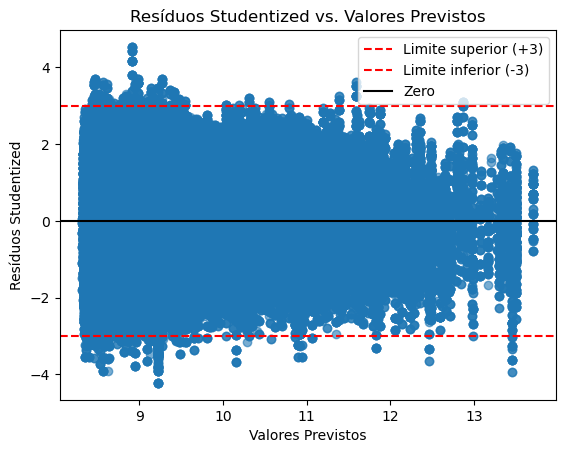

In [559]:
# Fórmula do modelo que estamos usando:
formula = '''log_renda ~ 
             tempo_emprego_lowess
             +1'''

# Gerando as matrizes X (variáveis independentes) e y (variável dependente):
y, X = patsy.dmatrices(formula, df_treino_b)

# Ajustando o modelo de regressão
model = sm.OLS(y, X).fit()

# Obtendo os resíduos studentized:
influence = model.get_influence()
studentized_residuals = influence.resid_studentized_internal

# Identificando valores extremos (fora de [-3, 3]):
extremos = np.where((studentized_residuals > 3) | (studentized_residuals < -3))
print("Índices de pontos discrepantes:", extremos)

# Obtendo valores previstos (fitted values):
fitted_values = model.fittedvalues

# Visualizando os resíduos studentized:
plt.scatter(fitted_values, studentized_residuals, alpha=0.6)
plt.axhline(y=3, color='r', linestyle='--', label='Limite superior (+3)')
plt.axhline(y=-3, color='r', linestyle='--', label='Limite inferior (-3)')
plt.axhline(y=0, color='black', linestyle='-', label='Zero')
plt.xlabel("Valores Previstos")
plt.ylabel("Resíduos Studentized")
plt.title("Resíduos Studentized vs. Valores Previstos")
plt.legend()
plt.show()

In [561]:
#Deixando so extremos em formato de lista para casar:
extremos = np.array(extremos).flatten().tolist()

# Removendo os índices dos outliers do DataFrame:
df_treino_b_sem_outliers = df_treino_b.drop(index=extremos)

# Verificando o tamanho antes e depois:
print("Tamanho original:", df_treino_b.shape[0])
print("Tamanho sem outliers:", df_treino_b_sem_outliers.shape[0])

Tamanho original: 600000
Tamanho sem outliers: 598910


In [563]:
#Quinto modelo: Com Suavização LOWESS
X2 = patsy.dmatrices('''log_renda ~ 
                    + tempo_emprego_lowess 
                    + 1''', df_treino_b_sem_outliers)

res_teste_1 = smf.ols(X2, data=df_treino_b_sem_outliers).fit()
res_teste_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 4.349e+05
Date:                Mon, 20 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:44:55   Log-Likelihood:            -8.0493e+05
No. Observations:              598910   AIC:                         1.610e+06
Df Residuals:                  598908   BIC:                         1.610e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0173      0.014      1.225      0.221      -0.010       0.045
tempo_emprego_lowess     0.9971      0.002    659.460      0.000       0.994       1.000
==============================================================================
Omnibus:                      866.750   Durbin-Watson:                   1.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              773.346
Skew:                          -0.047   Prob(JB):                    1.17e-168
Kurtosis:                       2.851   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Novamente, sem aumento do $R^2$, logo, manteremos o modelo sem a exclusão dos outliers.

Para finalizar, iremos ver o desempenho do nosso novo modelo **log renda ~ tempo_emprego_lowess** na base de teste, mas antes, vamos organizar a base de teste com log_renda e tempo_emprego_lowess.

In [578]:
# 1º passo) criação de df_teste_b com as mesmas variáveis de df_treino_b:
df_teste_b = df_teste[['renda', 'posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego']]

#2º passo) Criação do log de renda dentro do df_treino_b:
df_teste_b['log_renda']= np.log(df_teste_b['renda'])
df_teste_b.head()

,renda,posse_de_imovel,qtd_filhos,idade,tempo_emprego,log_renda
633328,1364.05,N,0,63,7.746165,7.218213
633329,4856.40,S,0,59,7.746165,8.488053
633330,9885.74,S,0,54,7.746165,9.198849
633331,5489.06,N,0,32,2.446575,8.610512
633332,3421.59,S,0,43,3.843836,8.137861


In [580]:
#3º passo: Definição da suavização dos dados na variável lowess

lowess = sm.nonparametric.lowess(df_teste_b.log_renda, df_teste_b.tempo_emprego, frac=2/3)

# Extrai os valores de tempo_emprego (x) e log_renda suavizado (y)
lowess_x = lowess[:, 0]  # Valores de tempo_emprego
lowess_y = lowess[:, 1]  # Valores suavizados de log_renda

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_teste_b['tempo_emprego_lowess'] = f(df_teste_b.tempo_emprego)
df_teste_b.head(2)

,renda,posse_de_imovel,qtd_filhos,idade,tempo_emprego,log_renda,tempo_emprego_lowess
633328,1364.05,N,0,63,7.746165,7.218213,8.041415
633329,4856.40,S,0,59,7.746165,8.488053,8.041415


In [583]:
# Previsão Modelo 2 - LOWES
df_teste_b['pred_2'] = res2.predict(df_teste_b)
r = df_teste_b[['pred_2', 'log_renda']].corr().iloc[0, 1]
print(f'R² Teste (Modelo 2): {r**2:.2%}')

R² Teste (Modelo 2): 52.58%


Diminuição pequena do $R^2$, mas remoção de 3 variáveis, trazendo um modelo mais simples e com praticamente a mesma explicabilidade. 